In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

from lib import calculate_normalize as CalNorm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [3]:
EPOCHS = 50
BATCH_SIZE = 128

In [ ]:
# 데이터셋에서 평균과 표준편차를 구하는 lib.py 작성
trainset = datasets.CIFAR100('./.data',
                             train=True,
                             download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))

testset = datasets.CIFAR100('./.data',
                             train=False,
                             download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))

# lib.py -> calculate_normalize()
mean_, std_ = CalNorm(trainset)
print("mean = {}\nstd = {}".format(mean_, std_))

Files already downloaded and verified
Files already downloaded and verified
mean = (0.50707513, 0.48654887, 0.44091785)
std = (0.20079845, 0.19834627, 0.20219834)


In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./.data',
                    train=True,
                    download=True,
                    transform=transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean_, std_)])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./.data',
                    train=False, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean_, std_)])),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [ ]:
# 기존의 2개의 블럭 계산 후 초기값을 + 하는 과정은 수정하지 않았습니다.
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                                stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                            nn.Conv2d(in_planes, planes,
                            kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(planes)
                            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# 책 내용의 코드는 간소화시킨 모델이였기에 채널 수를 늘리고 레이어 깊이를
# 기존 ResNet 34 레이어 모델과 동일하게 하였습니다.
class ResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet, self).__init__()
        # 기본 채널 수 64개로 변경
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 3, stride=1) # 64 3X3 6개
        self.layer2 = self._make_layer(128, 4, stride=2) # 128 3X3 8개
        self.layer3 = self._make_layer(256, 6, stride=2) # 256 3X3 12개
        # 레이어 추가
        self.layer4 = self._make_layer(512, 3, stride=2) # 512 3X3 6개  
        # 총 레이어 갯수 = input layer + 32개 + output layer = 34개

        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # 평균 풀링 커널 수 8 -> 4
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [9]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) # 학습 데이터를 DEVICE의 메모리로 보냄
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
loss = []
accuracy = []

In [12]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer)
    test_loss, test_accuracy= evaluate(model, test_loader)
    loss.append(test_loss)
    accuracy.append(test_accuracy)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

c:\Users\sogno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[1] Test Loss: 3.8450, Accuracy: 9.26%
[2] Test Loss: 3.4662, Accuracy: 16.71%
[3] Test Loss: 3.1695, Accuracy: 22.59%
[4] Test Loss: 2.8267, Accuracy: 29.75%
[5] Test Loss: 2.5578, Accuracy: 34.42%
[6] Test Loss: 2.3010, Accuracy: 38.97%
[7] Test Loss: 2.0947, Accuracy: 44.05%
[8] Test Loss: 2.0232, Accuracy: 45.70%
[9] Test Loss: 1.9240, Accuracy: 47.56%
[10] Test Loss: 1.8746, Accuracy: 48.35%
[11] Test Loss: 1.8032, Accuracy: 51.24%
[12] Test Loss: 2.0527, Accuracy: 47.08%
[13] Test Loss: 1.9440, Accuracy: 48.99%
[14] Test Loss: 1.6952, Accuracy: 54.42%
[15] Test Loss: 1.7868, Accuracy: 52.46%
[16] Test Loss: 1.8294, Accuracy: 52.19%
[17] Test Loss: 1.6722, Accuracy: 54.98%
[18] Test Loss: 1.6542, Accuracy: 55.80%
[19] Test Loss: 1.5272, Accuracy: 57.59%
[20] Test Loss: 1.6428, Accuracy: 55.28%
[21] Test Loss: 1.7013, Accuracy: 53.85%
[22] Test Loss: 1.7132, Accuracy: 54.92%
[23] Test Loss: 2.1093, Accuracy: 47.70%
[24] Test Loss: 1.7449, Accuracy: 53.40%
[25] Test Loss: 1.6106, Ac

In [13]:
PATH = './.models/ResNet_Custom_Model.pt'

In [14]:
torch.save(model.state_dict(), PATH)

In [15]:
loss = np.array(loss)
accuracy = np.array(accuracy)
epochs = np.array([x for x in range(1, EPOCHS + 1)])

In [16]:
df = pd.DataFrame({'epoch': epochs,
                   'loss': loss,
                   'accuracy': accuracy})
df.to_csv(".result/ResNet_Custom_result.csv", index=False)

Text(0, 0.5, 'Accuracy')

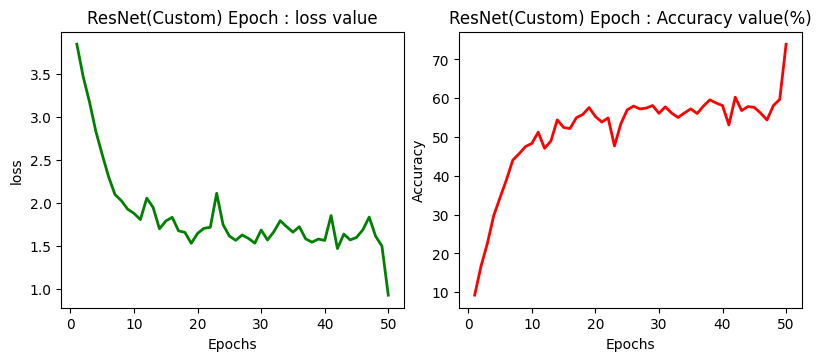

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3.5), layout="constrained")

axs[0].plot(epochs, loss, c='g', linewidth=2)
axs[0].set_title('ResNet(Custom) Epoch : loss value')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('loss')

axs[1].plot(epochs, accuracy, c='r', linewidth=2)
axs[1].set_title('ResNet(Custom) Epoch : Accuracy value(%)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')